In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this notebook you will learn how to implement a Flow Matching Algorithm to create Animals, Note that you could change the Dataset and create different objects.

This is aswell Part of the project presented at ICRA 2026, made by @eduardoHernandez and @UlisesDiaz.

Each section will have a Mathematical Explation, the goal is to make it easier to understand. Thus, it will have several animations to make you understand

Note that this is animations and the mathematical explanation is not on the official Code.

We make this to help the community into this topic.

It is important to note that most of it, comes from : where, they explain each detail, so go and see it.


Hope you like it.


## 1. Install Dependencies

1.- Torch, torchvision, torchaudio,
2.- matplotlib , numpy, tqdm, pillow
3.- gdown
4.- einops

In [1]:
!pip install torch torchvision torchaudio
!pip install matplotlib numpy tqdm pillow
!pip install gdown # for dataset download
!pip install einops  #for tensor manipulation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

## 2. Initial Configuration

Standard Pytorch configurations


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from typing import Tuple, Optional
import math
import einops

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Usando dispositivo: cuda


## 3. Download and Prepare Dataset

Note that you can change for any dataset you want, the code should work the same

Download the dataset in: https://www.dropbox.com/scl/fi/kpxh6hu04eu28yb8l30wy/afhq.zip?e=2&rlkey=usjnva71u164xd4rq6ghlab1u&dl=0


In [14]:
import gdown
import zipfile

def download_ahfq_datset():
  urls = {
      'train' : '/content/drive/MyDrive/Research/Flow_Reinforcement/afhq/train',
      'val' : '/content/drive/MyDrive/Research/Flow_Reinforcement/afhq/val'
  }

  os.makedirs('data', exist_ok=True)

  for split, url in urls.items():
    output_path = f'data/afhq_{split}.zip'
    if not os.path.exists(output_path):
      print(f"Descargando {split} set ...")
      gdown.download(url, output_path, quiet=False)

      #extraer data
      with zipfile.ZipFile(output_path, 'r') as zip_ref :
        zip_ref.extractall('data/')
      print(f"{split} set descargado y extraido")



## 4. Using the Dataset

Here,  we sample and get the transforms of the Dataset Above

Dataset cargado: 7813 imágenes
Dimensiones de imagen: 64x64


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


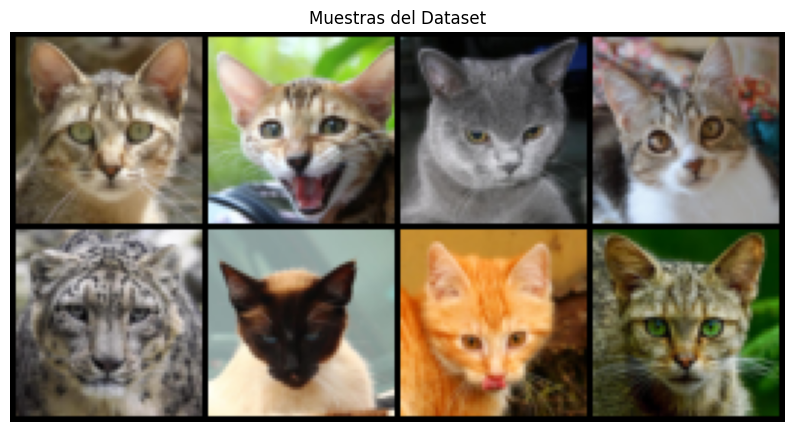

In [18]:
def get_transforms(image_size=64):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizar a [-1, 1]
    ])

# Crear dataset personalizado
class AnimalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []

        # Buscar todas las imágenes en subdirectorios
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(root, file))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Configurar datasets y dataloaders
IMAGE_SIZE = 64
BATCH_SIZE = 32

transform = get_transforms(IMAGE_SIZE)

train_dataset = AnimalDataset('/content/drive/MyDrive/Research/Flow_Reinforcement/afhq/train', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print(f"Dataset cargado: {len(train_dataset)} imágenes")
print(f"Dimensiones de imagen: {IMAGE_SIZE}x{IMAGE_SIZE}")

# Visualizar algunas imágenes del dataset
def show_samples(loader, num_samples=8):
    batch = next(iter(loader))
    images = batch[:num_samples]

    # Desnormalizar para visualización
    images = (images + 1) / 2

    grid = make_grid(images, nrow=4, padding=2)
    plt.figure(figsize=(10, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Muestras del Dataset")
    plt.axis('off')
    plt.show()

show_samples(train_loader)

# 5. Initial Gaussian Distribution

Here we start seeing actual stuff on Flow Matching.

Fist, we need a classs to manage the sampling of Gaussian Distribution x0 , we start from pure noise (Gaussian Distribution) to real data (images)


To see the explanation of Flow Matching and the Notes of the paper, see `section 0`

The explanation of this Part is in Lecture 1. Go and see it.




forma del ruido : torch.Size([16, 3, 64, 64])
Rango valores : [-4.675, 4.214]
Media : -0.003, Std: 1.005
Forma de log_probs : torch.Size([16])


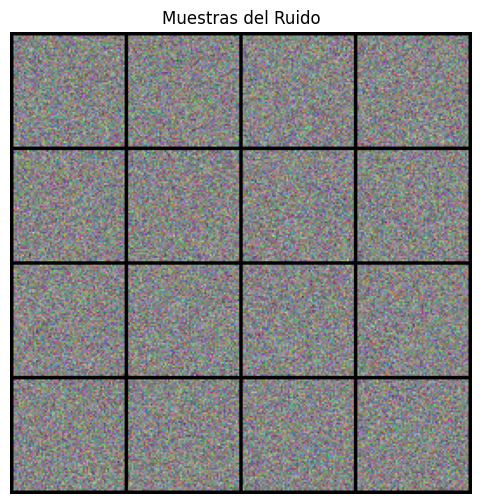

In [30]:
import torch
import numpy as np
from typing import Tuple
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Definir variables de ejemplo para que el código sea ejecutable
IMAGE_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# SAMPLIGN
class GaussianNoiseSource  :
  '''
  Clase para manejar el muestreo de la distribucion Gaussaiana inicial x_0
  Para Flow Matching, iniciamos desde ruido puro y "fluimos" hacia datos reales
  '''
  def __init__(self, shape:Tuple[int, ...], device : str = 'cpu'):
    '''
    Argumentos :
      shape : Forma de las Imagenes, en este caso, (Channel, Height , Width)
      device : Dispositivo para generar muestras
    '''
    self.shape = shape
    self.device = device


  def sample (self, batch_size : int) -> torch.Tensor :
    # Shows Initial Gaussian Distribution x_0 , N(0, I), explicar que es esto
    # Need a Batch size and Returns Tensor Shape
    return torch.randn(batch_size, *self.shape, device = self.device)

  def log_prob (self, x: torch.Tensor) -> torch.Tensor:
    '''
    Calcula log px(x) para x ~ N (0 , I)
    Args :
      x : Tensor de Muestras
    Returns :
      Log-likelihood shape (batch_size)
    '''
    # Log-likelihood gaussian
    dim = torch.prod(torch.tensor(self.shape, device = x.device))
    log_prob = -0.5 * dim * torch.log(torch.tensor(2 * np.pi , device = x.device)) - 0.5 * x.pow(2).sum(dim=(1, 2, 3))
    return log_prob

# Generar Ruido
noise_source = GaussianNoiseSource(shape=(3, IMAGE_SIZE, IMAGE_SIZE), device = device)

def gaussian_sampling():
  noise_samples = noise_source.sample(16)

  # calcular log-likelihood
  log_probs = noise_source.log_prob(noise_samples)

  print(f'forma del ruido : {noise_samples.shape}')
  print(f'Rango valores : [{noise_samples.min():.3f}, {noise_samples.max():.3f}]')
  print(f'Media : {noise_samples.mean():.3f}, Std: {noise_samples.std():.3f}')
  print(f'Forma de log_probs : {log_probs.shape}')

  # Visualize noise
  noise_grid = make_grid(noise_samples.cpu(), nrow = 4 , padding=2, normalize = True)
  plt.figure(figsize=(10, 6))
  plt.imshow(noise_grid.permute(1, 2, 0))
  plt.title('Muestras del Ruido')
  plt.axis('off')
  plt.show()

gaussian_sampling()

Vector Field